# DEMNet: 全球3弧秒（90m）海陆高分辨率数字高程模型

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindearth/zh_cn/dem-super-resolution/mindspore_DEMNet.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindearth/zh_cn/dem-super-resolution/mindspore_DEMNet.py)&emsp;[![ViewSource](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindearth/docs/source_zh_cn/dem-super-resolution/DEMNet.ipynb)


## 概述

DEMNet是数字高程模型网络的简称，可以提供准确的基础地理数据，因此在全球气候变化、海洋潮汐运动、地球圈物质交换等研究领域发挥着至关重要的作用。在探索海洋地形的地理分布和板块运动模式之前，必须克服精细建模的关键理论和技术障碍。直到2020年代，分辨率超过100米的全球DEM才出现，当时全球30米分辨率的陆地NASADEM和FABDEM都免费提供。由于数据量大，制作更高分辨率的全球DEM地图需要更多的时间和计算资源。由于分辨率和传感器的不同，这些数据融合存在各种精度困难。一种称为超分辨率(SR)的深度学习技术已用于识别和补偿分辨率和传感器之间的差异。30米分辨率的NASADEM、GEBCO_2021数据和众多高分辨率(HR)区域海洋DEM数据集都是公开可用的，使得生成具有3弧秒分辨率的全球DEM数据集成为可能。

本教程介绍了DEMNet的研究背景和技术路径，并展示了如何通过MindSpore Earth训练和快速推断模型。 更多信息可以在以下位置找到：[paper](https://pubmed.ncbi.nlm.nih.gov/36604030/).

## 技术路径

MindSpore Earth解决这个问题的具体流程如下：

1. 创建数据集
2. 模型构建
3. 损失函数
4. 模型训练
5. 模型评估和可视化

## DEMNet

基于深度残差网络的DEMNet的预训练数据来源于地面DEM数据。如图所示，设计的预训练结构源自增强型深度超分辨率网络（EDSR）。DEMNet网络的第一个卷积层提取特征集合。EDSR模型默认的残差块数量扩大到32。通过实验比较，最佳残差块数量（ResBlocks）为42，每个残差块由两个卷积层组成，并用ReLU激活函数进行插值。最后，由卷积层和逐元素加法层组成。后者包括用于提取特征图的卷积层，利用比例因子为5的插值层从输入的低分辨率15角秒数据上采样到目标高分辨率3角秒数据，最后，卷积层聚合低分辨率空间中的特征图并生成SR输出数据。与典型的反卷积层相反，使用插值函数层，可以对低分辨率数据进行超分辨率，具备更好的效果。

该网络由88个卷积层、43个元素加法层和1个插值层组成。每个卷积层中的卷积核大小设置为3，填充设置为1。总共有50,734,080个网络参数。在训练阶段，使用初始学习率为0.0001的Adam优化器和指数衰减方法使用大数据集来训练模型。当模型的性能在验证集中开始劣化时，使用为容忍度为6的早停技术来终止训练，以防止过度拟合。小批量梯度下降法通常需要300个epoch才能从头开始构建预训练网络。初始参数源自地面数据预训练网络，预训练网络的冻结层与海洋DEM结合使用，以微调全局DEMNet模型。 由于微调样本有限，学习率对收敛过程有显着影响，并将学习率调整为0.00001。

![DEM_SR](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindearth/docs/source_zh_cn/dem-super-resolution/images/dem_DEMNet.png)

模型训练分为两个步骤：

1. 预训练：如上图所示，在预训练步骤中，预训练的DEMNet网络的第一个卷积层提取特征集合。EDSR模型默认残差块数已扩展至32。

2. 微调：本文的主要贡献是使用GEBCO_2021和NASADEM陆地样本预训练神经网络模型，然后使用有限的区域海洋DEM数据进行额外的微调。

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from mindspore import context, nn, Tensor
from mindspore import load_checkpoint, load_param_into_net
from mindspore.train import LossMonitor, TimeMonitor

from mindearth.utils import load_yaml_config, create_logger
from mindearth.module import Trainer
from mindearth.data import DemData, Dataset

 `src` 文件可以从[DEM super-resolution/src](https://gitee.com/mindspore/mindscience/tree/master/MindEarth/applications/dem-super-resolution/src)下载。

In [2]:
from src import init_model, plt_dem_data
from src import EvaluateCallBack, InferenceModule

context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=0)

model、data和optimizer的参数可以通过加载[DEMNet.yaml](https://gitee.com/mindspore/mindscience/tree/master/MindEarth/applications/dem-super-resolution/DEMNet.yaml)文件获取。

In [3]:
config = load_yaml_config('DEMNet.yaml')

config['train']['distribute'] = False # set the distribute feature
config['train']['amp_level'] = 'O2' # set the level for mixed precision training
config["train"]["load_ckpt"] = False # 是否加载预训练checkpoint

config['data']['num_workers'] = 1  # set the number of parallel workers
config['data']['epochs'] = 100 # set the train epochs

config['summary']["valid_frequency"] = 100 # set the frequency of validation
config['summary']["summary_dir"] = './summary' # set the directory of model's checkpoint

logger = create_logger(path=os.path.join(config['summary']["summary_dir"], "results.log"))

## 创建数据集

从[dataset](https://download.mindspore.cn/mindscience/mindearth/dataset/dem_dataset.zip)下载训练数据集、验证数据集、测试数据集到当前目录`./dataset`。

修改[DEMNet.yaml](https://gitee.com/mindspore/mindscience/tree/master/MindEarth/applications/dem-super-resolution/DEMNet.yaml)配置文件中的`root_dir`参数，该参数设置了数据集的路径。

`./dataset`中的目录结构如下所示：

```markdown
.
├── train
│   └── train.h5
├── valid
│   └── valid.h5
├── test
│   └── test.h5
```


## 模型构建

初始化Dem模型。

In [4]:
model = init_model(config)

## 损失函数

DemNet使用均方误差进行模型训练。

In [5]:
loss_fn = nn.MSELoss()

## 模型训练

在本教程中，我们继承Trainer并重写get_callback成员函数，以便我们可以在训练过程中对测试数据集进行推理。

随着MindSpore版本>=1.10.1，我们可以使用函数式编程来训练神经网络。MindEarth提供了模型训练的训练接口。

In [6]:
class DemSrTrainer(Trainer):
    r"""
    Self-define forecast model inherited from `Trainer`.

    Args:
        config (dict): parameters for training.
        model (Cell): network for training.
        loss_fn (str): user-defined loss function.
        logger (logging.RootLogger): tools for logging.

    Supported Platforms:
        ``Ascend`` ``GPU``

    """
    def __init__(self, config, model, loss_fn, logger):
        super(DemSrTrainer, self).__init__(config, model, loss_fn, logger, weather_data_source="DemSR")
        self.model = model
        self.optimizer_params = config["optimizer"]
        self.train_dataset, self.valid_dataset = self.get_dataset()
        self.optimizer = self.get_optimizer()
        self.solver = self.get_solver()

    def get_optimizer(self):
        r"""define the optimizer of the model, abstract method."""
        self.steps_per_epoch = self.train_dataset.get_dataset_size()
        if self.logger:
            self.logger.info(f'steps_per_epoch: {self.steps_per_epoch}')
        if self.optimizer_params['name']:
            optimizer = nn.Adam(self.model.trainable_params(),
                                learning_rate=Tensor(self.optimizer_params['learning_rate']))
        else:
            raise NotImplementedError(
                "self.optimizer_params['name'] not implemented, please overwrite get_optimizer()")
        return optimizer

    def get_callback(self):
        r"""define the callback of the model, abstract method."""
        pred_cb = EvaluateCallBack(self.model, self.valid_dataset, self.config, self.logger)
        return pred_cb

    def train(self):
        r""" train """
        callback_lst = [LossMonitor(), TimeMonitor(), self.ckpt_cb]
        if self.pred_cb:
            callback_lst.append(self.pred_cb)
        self.solver.train(epoch=config['data']['epoch_size'],
                          train_dataset=self.train_dataset,
                          callbacks=callback_lst,
                          dataset_sink_mode=True)
trainer = DemSrTrainer(config, model, loss_fn, logger)

2023-09-27 10:33:38,449 - 3395036387.py[line:27] - INFO: steps_per_epoch: 109


In [7]:
trainer.train()

epoch: 1 step: 109, loss is 0.0018688203
Train epoch time: 55616.483 ms, per step time: 510.243 ms
epoch: 2 step: 109, loss is 0.0008327974
Train epoch time: 31303.473 ms, per step time: 287.188 ms
epoch: 3 step: 109, loss is 0.00022218125
...
epoch: 98 step: 109, loss is 1.3421039e-05
Train epoch time: 29786.506 ms, per step time: 273.271 ms
epoch: 99 step: 109, loss is 1.113452e-05
Train epoch time: 31082.307 ms, per step time: 285.159 ms
epoch: 100 step: 109, loss is 2.0731915e-05
Train epoch time: 30750.022 ms, per step time: 282.110 ms


## 模型评估及可视化

In [8]:
params = load_checkpoint("./summary/ckpt/step_/DemSrNet_7-100_109.ckpt")
load_param_into_net(model, params)

inference_module = InferenceModule(model, config, logger)
test_dataset_generator = DemData(data_params=config["data"], run_mode='test')
test_dataset = Dataset(test_dataset_generator, distribute=False,
                       num_workers=config["data"]['num_workers'], shuffle=False)
test_dataset = test_dataset.create_dataset(config["data"]['batch_size'])
create_test_data = test_dataset.create_dict_iterator()

下图对第100个模型的真实值和预测值进行了可视化。

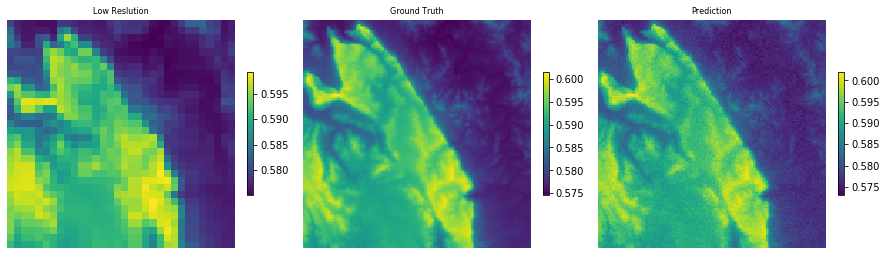

In [9]:
data = next(create_test_data)

inputs = data['inputs']
labels = data['labels']

low_res = inputs[0].asnumpy()[0].astype(np.float32)
pred = inference_module.forecast(inputs)
pred = pred[0].asnumpy()[0].astype(np.float32)
label = labels[0].asnumpy()[0].astype(np.float32)

plt.figure(num='e_imshow', figsize=(15, 36))
plt.subplot(1, 3, 1)
plt_dem_data(low_res, "Low Reslution")
plt.subplot(1, 3, 2)
plt_dem_data(label, "Ground Truth")
plt.subplot(1, 3, 3)
plt_dem_data(pred, "Prediction")
